# Single analysis notebook

This notebook aims to create enviroment to simply test strategies developed in Stocks & Loss system for python

In [43]:
# imports 
from scraper import stock_daily
from analyzer import Analyzer
from IPython.display import display

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

## Settings
* Select stock ticker
* Define buy and sell strategy (buystrat and sellstrat)
* Define if you want to run stop loss and what value
* Same with profit taker

In [44]:
ticker = "SLAB"

buystrat = ["Mcstoch_ut1", "Mcstoch_ut2", "Mcstoch_ut3", "Mcstoch_ut4", "Mcstoch_dt1"]
sellstrat = ['Mcstoch']

sl = True
slval = 0.04

pt = True
ptval = 0.1

rb = True

## Run calculation

In [45]:
# scraping / loading data
stock = stock_daily(ticker, delta=dt.timedelta(days=165),save=False)
# creating analyzer instance
trades = Analyzer(ticker=ticker, data=stock.data)
# building strategy
trades.strategy(buyStrategy=buystrat, sellStrategy=sellstrat,
    stopLoss=sl ,stopLossValue=slval, profitTaker=pt, profitTakerValue=ptval, repeated_buys=rb)
# evaluating strategy
summary = trades.profit(capitalForEachTrade=400, comission=2)
profitByHolding = 100*((trades.data["Close"].iloc[-1]-trades.data["Close"].iloc[0])/trades.data["Close"].iloc[0])

# dates for plot
# taking stock.data and changing index to column and Date to index
dates = stock.data.copy()
dates["index1"] = dates.index
dates = dates.set_index("Date")

# find index of buy dates of good trades
bdg = summary["Buy date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdg = summary["Sell date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdg = dates["index1"].reindex(bdg).to_numpy()
sdg = dates["index1"].reindex(sdg).to_numpy()
   
# find index of buy dates of bad trades
bdb = summary["Buy date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdb = summary["Sell date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdb = dates["index1"].reindex(bdb).to_numpy()
sdb = dates["index1"].reindex(sdb).to_numpy()

In [46]:
print('Absolute profit last year:                ',np.round(summary["Profit[$]"].sum(),2),'$')
print('Relative profit last year:                ',np.round(summary["Profit[%]"].sum(),2),'%')
print('Relative profit by holding last year:     ',np.round(profitByHolding,2),'%')

Absolute profit last year:                 38.0 $
Relative profit last year:                 9.5 %
Relative profit by holding last year:      0.21 %


In [47]:
display(summary)

,Buy date,Buy price,Buy value,Position,Sell date,Sell price,Sell value,Comission,Good trade?,Profit[%],Profit[$]
0,2021-06-10,137.399994,400,2.911208,2021-06-28,151.139993,440.0,2,1.0,9.5,38.0


## Visualizations

Successful trades are showcased as a light green fill, similarly, failed trades as a red fill

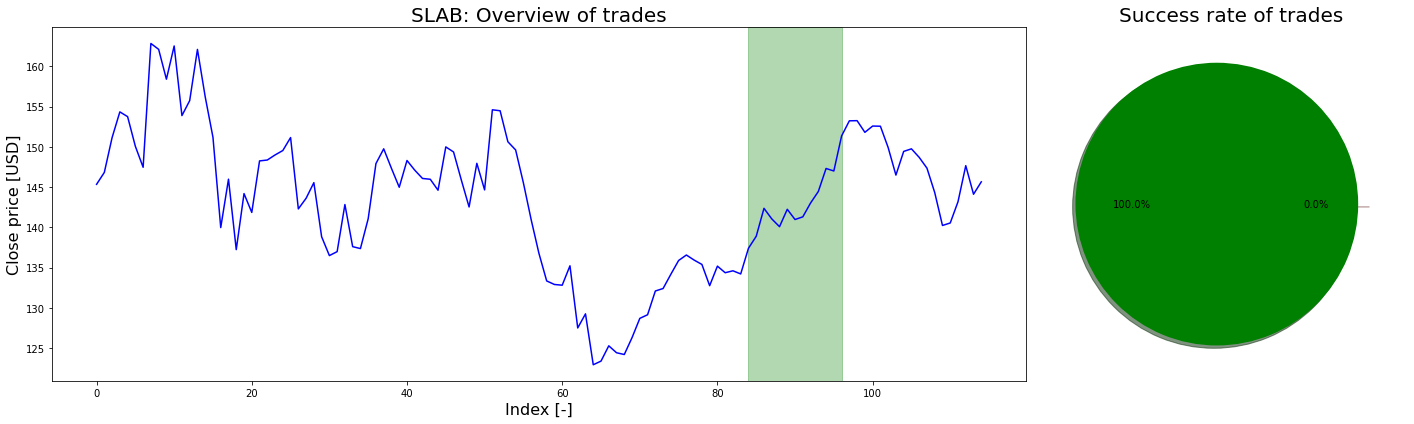

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw={'width_ratios': [2.5, 1]})

# plot closed prices and highlighted trades
ax[0].plot(stock.data["Close"], color="b")
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlabel("Index [-]", fontsize=16)

gtrades = summary["Good trade?"].sum()
trades = summary["Good trade?"].size
# plot piechart with percentage of succesful trades (profit / loss)
ax[1].pie([gtrades, trades-gtrades], colors=["g","r"], shadow=True, explode=(0.1, 0), autopct="%1.1f%%")
ax[1].set_title("Success rate of trades", fontsize=20)

fig.tight_layout()